In [3]:
import sys
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk"))

# ROOT!
import os, sys
os.environ["ROOTSYS"] = "/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/software/ROOT/ROOT_6.26.14/install"
sys.path.append(os.path.join(os.environ["ROOTSYS"], "lib"))

import hipy.hipy.pltext  as pltext
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import pandas            as pd

from nHits_trigger.src.read_data          import nHits, read_mpmt_offsets
from WCTE_BRB_Data_Analysis.wcte.brbtools import sort_run_files, get_part_files

from tqdm import tqdm

pltext.style()

In [4]:
datapath="/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/nicf_data/data/"
filename="run_1766_signal_N20candidates_unfiltered.csv"
data = pd.read_csv(datapath+filename)

In [5]:
data

,event_id,hit_pmt_calibrated_times,hit_pmt_charges,hit_mpmt_card_ids,hit_mpmt_slot_ids,hit_pmt_channel_ids,hit_pmt_position_ids
0,0.0,76264.181597,79.0,27.0,2.0,9.0,3.0
1,0.0,76273.067467,209.0,118.0,55.0,3.0,18.0
2,1.0,209221.084343,103.0,114.0,19.0,13.0,12.0
3,1.0,209223.152791,119.0,114.0,19.0,12.0,4.0
4,1.0,209233.144440,175.0,114.0,19.0,10.0,10.0
...,...,...,...,...,...,...,...
2708303,383767.0,312021.117926,227.0,44.0,43.0,17.0,15.0
2708304,383767.0,312022.556373,69.0,36.0,46.0,10.0,10.0
2708305,383768.0,405073.289513,204.0,104.0,40.0,4.0,1.0
2708306,383768.0,405081.234585,142.0,89.0,89.0,18.0,16.0


In [ ]:
#HISTOGRAMA DE CARGA TOTAL POR EVENTO, prueba1

#cada fila de datos es un hit=llega un fotón
#Evento: período de tiempo fijo en el que se recogen hits

In [8]:
#1º) Agrupo los hits en sus respectivos eventos

# Tenemos 2708308 hits en total, pero queremos agruparlos en el evento en el que llegaron: evento 0, 1,..., 383768 (event_id)

data_by_event=data.groupby("event_id") # .groupby("event_id") toma todas las filas con el mismo event_id y las junta en grupos

print(len(data_by_event)) #para ver cuántos grupos tengo uso len(); lo imprimo para verlo
#este es el nº de valores diferentes que tengo de event_id, que coincide con 0+383768=383769

383769


In [11]:
#2º) Calculo la carga total en cada grupo (en cada evento): sumamos las cargas en cada grupo

total_charge_by_event=data_by_event["hit_pmt_charges"].sum() #data_by_event["hit_pmt_charges"] con los [] seleccionamos
#la columna hit_pmt_charges de cada grupo y luego sumamos sus valores
print(total_charge_by_event)

#==============CHATTY===========================================
# Busco los 30 eventos con más hits
top_30_charge=total_charge_by_event.nlargest(30) #crea una serie con los 30 valores más grandes de total_charge_by_event

print("="*60)
print("TOP 30 EVENTOS CON MÁS CARGA TOTAL")
print("="*60)

# Convertir a DataFrame con ranking desde 1
top_30_df = top_30_charge.reset_index()
top_30_df.columns = ['event_id', 'carga total']
top_30_df.index = top_30_df.index + 1
top_30_df.index.name = 'ranking'  # Nombre del índice

print(top_30_df)
#==============CHATTY===========================================

event_id
0.0          288.0
1.0          397.0
2.0          561.0
3.0          577.0
4.0          335.0
             ...  
383764.0     392.0
383765.0     248.0
383766.0     355.0
383767.0    1647.0
383768.0     588.0
Name: hit_pmt_charges, Length: 383769, dtype: float64
TOP 30 EVENTOS CON MÁS CARGA TOTAL
         event_id  carga total
ranking                       
1        140862.0     285597.0
2        194402.0     280167.0
3        299900.0     273509.0
4        367856.0     271327.0
5        216203.0     265892.0
6        137220.0     260691.0
7        214897.0     250384.0
8        304099.0     234169.0
9        224042.0     232087.0
10       178871.0     225098.0
11       364906.0     221458.0
12       349376.0     218238.0
13       102569.0     217931.0
14       358273.0     214507.0
15       104532.0     214048.0
16        58144.0     213593.0
17       304393.0     209801.0
18        37645.0     209506.0
19       348470.0     209470.0
20       321828.0     208419.0
21       37

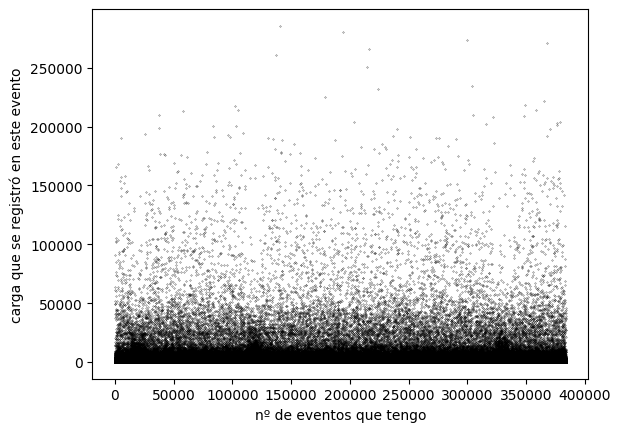

In [12]:
#3º) Puedo representar carga total vs grupo para visualizar cuánta carga se registró en cada evento

#Eje x= índice del grupo, data_by_event (desde 0 hasta 383768)
#Eje y= númeor de carga total dentro del grupo

plt.figure()
plt.scatter(total_charge_by_event.index, total_charge_by_event.values, s=0.05)
plt.xlabel("nº de eventos que tengo")
plt.ylabel("carga que se registró en este evento") #aquí no sé por qué pasa esto, debería haber sólo un valor??? creo q está bn así
plt.show()

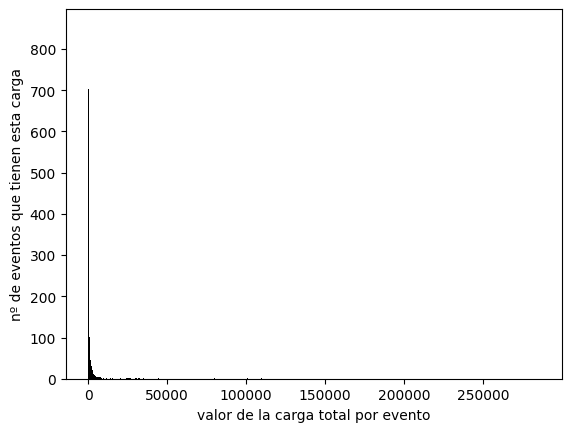

In [13]:
#4º) Ahora tengo que hacer el histograma

#usaremos: plt.hist(datos_que_queremos_graficar, bins=nº_de_barras)

charge=total_charge_by_event.values

#np.arange(charge.min(), charge.max()+2) crea un array que va desde el mínimo hasta el máx+2 de carga total por evento (por grupo)
#se le resta 0.5 para centrar las barras del histograma en los valores enteros

bins=np.arange(charge.min(), charge.max()+2) - 0.5 

plt.figure()
plt.hist(charge, bins)
plt.xlabel("valor de la carga total por evento")
plt.ylabel("nº de eventos que tienen esta carga")
plt.show()